# Predicting Player Newsletter Subscription Using Gaming Behavior

**DSCI 100 Group Project Report**

## Introduction

Video gaming has become one of the most popular forms of entertainment worldwide, with millions of players engaging across various platforms and genres. For game developers and publishers, understanding player engagement is crucial for building lasting relationships with their audience. One key metric of player engagement is newsletter subscription, which indicates a player's interest in staying connected with the game community and receiving updates.

In this analysis, we aim to answer the following research question:

> **What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**

More specifically, can factors such as `Age` and `played_hours` predict newsletter subscription in the players dataset?

This question is significant because understanding subscription behavior can help game developers:
- Target marketing efforts more effectively
- Identify engaged players for community building
- Improve player retention strategies
- Personalize communication with different player segments

### Dataset Description

This project uses the dataset `players.csv` which contains information about individual players. The data was collected by the research group at [PlaiCraft.ai](https://plaicraft.ai).

| Variable Name  | Type      | Description                                     |
| -------------- | --------- | ----------------------------------------------- |
| `hashedEmail`  | Character | Unique identifier for each player (anonymized)  |
| `name`         | Character | Player name                                     |
| `gender`       | Character | Gender identity (7 levels)                      |
| `Age`          | Double    | Age in years                                    |
| `experience`   | Character | Player experience level (5 levels)              |
| `subscribe`    | Logical   | Subscribed to newsletter or not (**target**)   |
| `played_hours` | Double    | Total hours played                              |

**Dataset characteristics:**
- **Number of observations:** 196
- **Number of variables:** 7

The response variable `subscribe` indicates whether a player subscribes to the newsletter, while our primary predictors are `Age` and `played_hours`. Identifiers like `name` and `hashedEmail` are excluded as they are not relevant for prediction. Based on exploratory analysis, `gender` and `experience` showed little effect on subscription rates and will not be used as predictors.

## Methods & Results

### Loading Required Libraries

We begin by loading the necessary R packages for our analysis. We will use `tidyverse` for data manipulation and visualization, and `tidymodels` for our machine learning workflow.

In [1]:
# Load required libraries
# Use install.package('tidyverse'), install.package('tidymodels') if needed
library(tidyverse)
library(tidymodels)
library(repr)

# Set display options
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading the Data

We load the dataset directly from a URL to ensure reproducibility.

In [2]:
# Load data from URL
url <- "https://raw.githubusercontent.com/hanson777/dsci-100-individual-planning-stage/main/data/players.csv"
players <- read_csv(url)

head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Data Wrangling and Cleaning

Before performing our analysis, we need to clean and wrangle the data. This includes:
- Selecting relevant columns for our analysis (`Age`, `played_hours`, `subscribe`)
- Converting `subscribe` (target variable) to a factor for classification
- Checking for and handling missing values (note: `Age` has 2 missing values)
- Addressing the skewness in `played_hours` (highly skewed with many near-zero values)

In [5]:
# Data wrangling: select columns, convert subscribe to factor, handle NAs
players_cleaned <- players |>
    select(Age, played_hours, subscribe) |>
    mutate(subscribe = as_factor(subscribe)) |>
    drop_na()

glimpse(players_cleaned)

Rows: 194
Columns: 3
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ subscribe    <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…


### Exploratory Data Analysis

Before building our classification model, we conduct exploratory data analysis to understand the distribution of our variables and identify potential patterns in the data.

#### Summary Statistics

We first examine summary statistics for our numerical variables to understand the central tendencies and spread of the data.

**Numeric Variables:**

| Variable       | Mean  | SD    | Min  | Median | Max    |
| -------------- | ----- | ----- | ---- | ------ | ------ |
| `Age`          | 21.14 | 7.39  | 9.00 | 19.00  | 58.00  |
| `played_hours` | 5.85  | 28.36 | 0.00 | 0.10   | 223.10 |

**Non-numeric Variables:**

| Variable    | Type    | Notes                          |
| ----------- | ------- | ------------------------------ |
| `subscribe` | Logical | 144 TRUE, 52 FALSE             |

In [43]:
# Summary statistics
players |> 
    summarize(
        mean_age = round(mean(Age, na.rm = TRUE), 2), 
        mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2)
    )

mean_age,mean_played_hours
<dbl>,<dbl>
21.14,5.85


#### Exploratory Visualizations

We create visualizations to explore the relationships between our predictor variables and the target variable (`subscribe`).

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


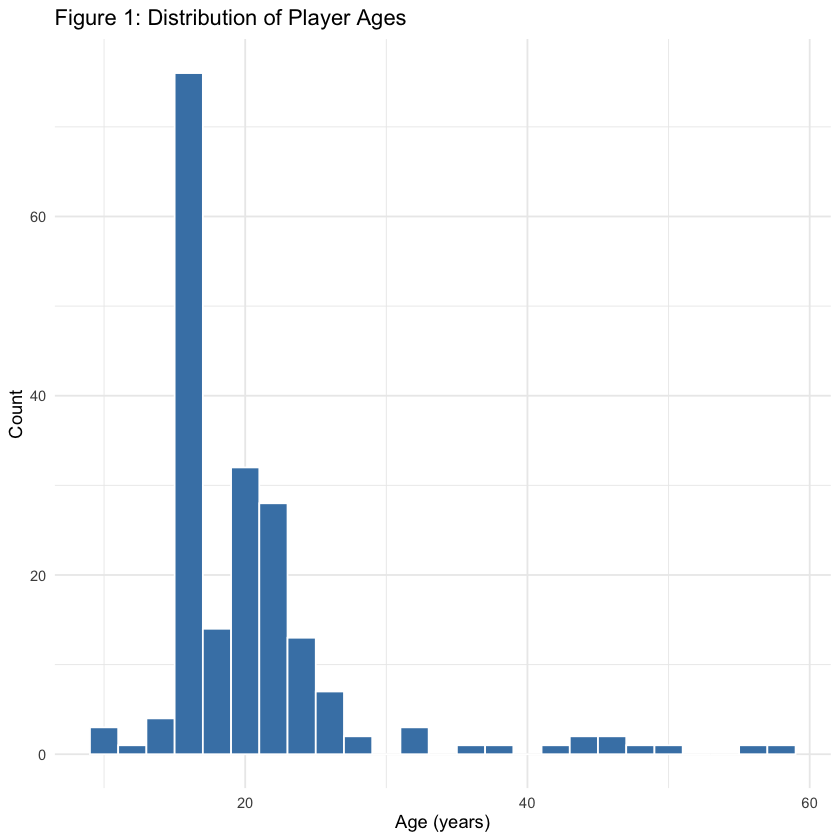

In [44]:
# Figure 1: Age distribution
ggplot(players, aes(x = Age)) +
    geom_histogram(binwidth = 2, fill = "steelblue", color = "white") +
    labs(title = "Figure 1: Distribution of Player Ages", x = "Age (years)", y = "Count") +
    theme_minimal()

**Figure 1: Distribution of Player Ages.** This histogram shows the age distribution of players in the dataset. The majority of players are young adults, with ages concentrated around 17-25 years old.

# Figure 2: Played hours by subscription (log-scaled due to skewness)
ggplot(players, aes(x = subscribe, y = log10(played_hours + 1), fill = subscribe)) +
    geom_boxplot() +
    labs(title = "Figure 2: Played Hours by Subscription Status", 
         x = "Subscribed", y = "Log10(Hours Played)") +
    theme_minimal() +
    theme(legend.position = "none")

**Figure 2: Played Hours by Subscription Status.** Subscribed players tend to have more hours played, indicating `played_hours` may predict subscription.

**Key Observations from EDA:**
- `Age` is mostly around 20 years old
- `played_hours` is highly skewed with many near-zero values
- Subscribed players tend to have more hours played
- `gender` has little effect on subscription and will not be used as a predictor
- Subscription rates are consistent across `experience` levels, therefore will not be used as a predictor
- Given these relationships, we can use a K-NN classification model

### Data Analysis: K-Nearest Neighbors Classification

We use K-NN to predict `subscribe` using `Age` and `played_hours`. K-NN suits binary classification and doesn't assume a specific relationship between predictors and outcome. Predictors must be standardized since K-NN is distance-based.

#### Train/Test Split

In [45]:
# Split data: 75% train, 25% test
set.seed(999)
players_split <- initial_split(players_cleaned, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

cat("Train:", nrow(players_train), "| Test:", nrow(players_test))

Train: 145 | Test: 49

#### Recipe and Model Specification

In [46]:
# Recipe: normalize predictors
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |> 
    step_center(all_predictors())

# KNN model spec with tunable k
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#### Cross-Validation to Find Optimal k

In [56]:
# 5-fold CV to tune k
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

k_grid <- tibble(neighbors = seq(1, 50, by = 2))

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |> 
    tune_grid(resamples = players_vfold, grid = k_grid) |> 
    collect_metrics()

accuracies <- knn_results |> 
    filter(.metric == 'accuracy')

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5029885,5,0.02720668,pre0_mod01_post0
3,accuracy,binary,0.5227586,5,0.05126926,pre0_mod02_post0
5,accuracy,binary,0.6062890,5,0.05865450,pre0_mod03_post0
7,accuracy,binary,0.6336617,5,0.06528431,pre0_mod04_post0
9,accuracy,binary,0.6336617,5,0.06618872,pre0_mod05_post0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
41,accuracy,binary,0.7311494,5,0.005037841,pre0_mod21_post0
43,accuracy,binary,0.7311494,5,0.005037841,pre0_mod22_post0
45,accuracy,binary,0.7311494,5,0.005037841,pre0_mod23_post0


We can visualize the graph of accuracy vs neighbors to get a general idea of how our model is performing with different values of k. 

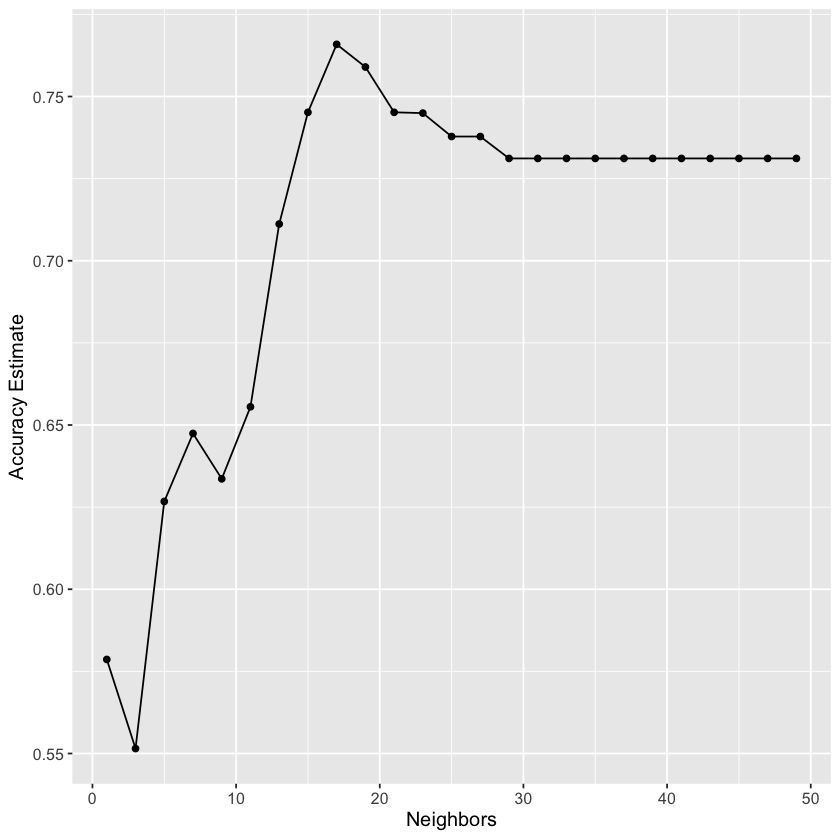

In [55]:

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

We can find the K value that maximizes accuracy by taking the value of ```neighbors``` in the ```accuracies``` dataframe where the ```mean``` variable is highest.

In [59]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k

[1] 17

Judging from our accuracy vs neighbors graph, there seems to be noticable dips in accuracy when selecting other values close to 17. Therefore, we should choose K = 17 to maximize our accuracy.

#### Final Model and Evaluation

In [62]:
# Evaluate on test set

players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

players_test_predictions <- knn_fit |>
    predict(players_test) |>
    bind_cols(players_test)

players_test_predictions |>
 metrics(truth = subscribe, estimate = .pred_class) |> 
 filter(.metric == 'accuracy')

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6734694


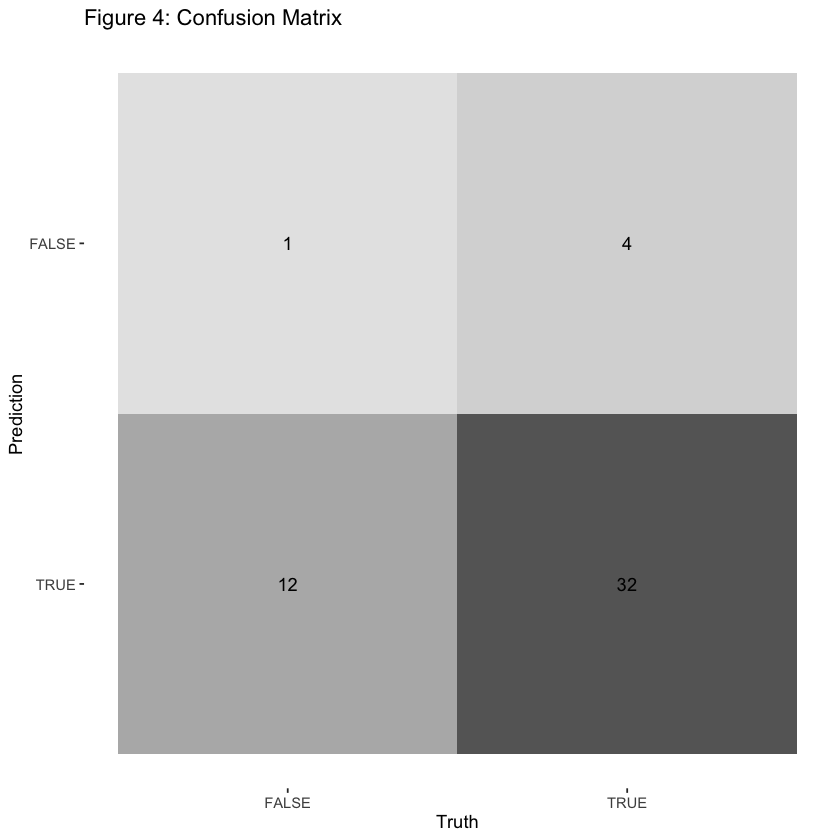

In [64]:
# Figure 4: Confusion matrix
players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class) |>
    autoplot(type = "heatmap") +
    labs(title = "Figure 4: Confusion Matrix")

**Figure X: Confusion Matrix.** Shows correct predictions (diagonal) vs misclassifications for subscriber prediction.

## Discussion

### Summary of Findings
[Summarize: test accuracy, optimal k, relationship between predictors and subscription]

### Expected vs. Actual Results
[Did `played_hours` predict subscription as expected? Was `Age` useful? Any surprises?]

### Impact and Implications
[How could this model help game developers with marketing/engagement strategies?]

### Limitations
- Small dataset (196 obs), class imbalance (144 TRUE vs 52 FALSE)
- Only 2 predictors; `played_hours` highly skewed
- K-NN sensitive to outliers

### Future Directions
[Could other features or algorithms improve accuracy? Longitudinal data?]